In [1]:
import numpy as np
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import PIL
import read_datasets as rd
import constants as CONST
from importlib import reload
reload(rd)
reload(CONST)
import pickle

In [2]:
import sys
sys.path.insert(0, "/home/xiaoyuz1/mnist-em-bmm-gmm")
import gmm

from IPython.display import SVG, display
import svgwrite # conda install -c omnia svgwrite=1.1.6

# Prepare features

In [3]:
# face_json = json.load(open(
#     '/raid/xiaoyuz1/sketch_datasets/SketchX-PRIS-Dataset/Perceptual Grouping/{}.ndjson'.format('face'), 
#     'r'))
# # face_json['train_data'][0]

In [4]:
# file to load? 
drawing_npz = np.load(
    '/raid/xiaoyuz1/sketch_datasets/sketchrnn_face.npz', 
    allow_pickle=True,
    encoding='latin1',
)
stroke_data_path = "/raid/xiaoyuz1/"
# keys: train, test, valid 

In [5]:
drawing_npz['train'][0].shape, drawing_npz['train'][1].shape

((83, 3), (76, 3))

## From: https://github.com/magenta/magenta-demos/blob/main/jupyter-notebooks/Sketch_RNN.ipynb

In [6]:

def get_bounds(data, factor=10):
    """Return bounds of data."""
    min_x = 0
    max_x = 0
    min_y = 0
    max_y = 0

    abs_x = 0
    abs_y = 0
    for i in range(len(data)):
        x = float(data[i, 0]) / factor
        y = float(data[i, 1]) / factor
        abs_x += x
        abs_y += y
        min_x = min(min_x, abs_x)
        min_y = min(min_y, abs_y)
        max_x = max(max_x, abs_x)
        max_y = max(max_y, abs_y)

    return (min_x, max_x, min_y, max_y)

def draw_strokes(data, factor=1, svg_filename = '/raid/xiaoyuz1/sample.svg'):
    # tf.gfile.MakeDirs(os.path.dirname(svg_filename))
    min_x, max_x, min_y, max_y = get_bounds(data, factor)
    
    dims = (50 + max_x - min_x, 50 + max_y - min_y)
    dwg = svgwrite.Drawing(svg_filename, size=dims)
    dwg.add(dwg.rect(insert=(0, 0), size=dims, fill='white'))
    
    lift_pen = 1
    abs_x = 25 - min_x 
    abs_y = 25 - min_y
    
    p = "M%s,%s " % (abs_x, abs_y)
    command = "m"
    for i in range(len(data)):
        if (lift_pen == 1):
            command = "m"
        elif (command != "l"):
            command = "l"
        else:
            command = ""
            
        x = float(data[i,0])/factor
        y = float(data[i,1])/factor
        lift_pen = data[i, 2]
        p += command+str(x)+","+str(y)+" "
        
    the_color = "black"
    stroke_width = 1
    dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))
    # dwg.save()
    display(SVG(dwg.tostring()))

In [7]:
# drawing_idx = 129
# draw_strokes(drawing_npz['train'][drawing_idx])

## process raw QuickDraw format

In [8]:
# drawing_raw = drawing_npz['train'][1000]
# drawing_raw = drawing_raw.astype(float)
# drawing_raw[:,0] = np.cumsum(drawing_raw[:,0], 0)
# drawing_raw[:,1] = np.cumsum(drawing_raw[:,1], 0)
# drawing_raw[:,0] += (25 - np.min(drawing_raw[:,0]))
# drawing_raw[:,1] += (25 - np.min(drawing_raw[:,1]))

# pen_lift_indices = np.where(drawing_raw[:,2] == 1)[0]+1
# strokes = np.vsplit(drawing_raw[:,:2].astype(float), pen_lift_indices)[:-1]
# strokes_spline_fitted = []
# for stroke in strokes:
#     stroke_sampled = rd.bspline(stroke, n=100, degree=3)
#     strokes_spline_fitted.append(stroke_sampled)

In [9]:
from tqdm import tqdm
all_stroke_data = []
for i in tqdm(range(2000)):
    drawing_raw = drawing_npz['train'][i]
    strokes = rd.process_quickdraw_to_stroke(drawing_raw)
    all_stroke_data.append(np.asarray(strokes))

100%|██████████| 3/3 [00:02<00:00,  1.18it/s]


In [14]:
np.savez_compressed('/raid/xiaoyuz1/face_stroke', train=np.asarray(all_stroke_data, dtype=object))

In [19]:
test = np.load('/raid/xiaoyuz1/face_stroke.npz',allow_pickle=True,encoding='latin1')['train']

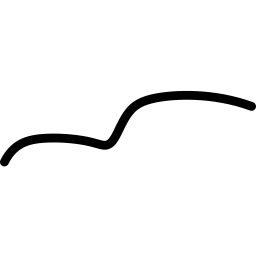

In [27]:
rd.render_img(
    [test[2][4]], 
    img_path=None, 
    show=False,
    side=256,
    line_diameter=1,
    padding=0,
    bg_color=(0,0,0),
    fg_color=(1,1,1),
    original_side = 28.,
    convert = True,
)

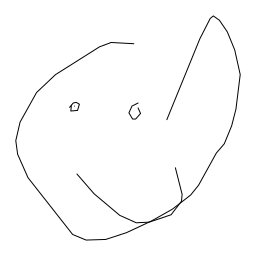

In [26]:
strokes = rd.quickdraw_to_vector(drawing_npz['train'][2])
rd.render_img(
    strokes, 
    img_path=None, 
    show=False,
    side=256,
    line_diameter=1,
    padding=0,
    bg_color=(0,0,0),
    fg_color=(1,1,1),
    original_side = 256.,
    convert = True,
)

## Fitting b-spline

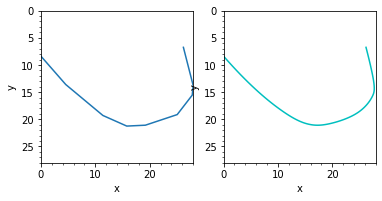

In [30]:
import numpy as np
import scipy.interpolate as si
import matplotlib.pyplot as plt
colors = ('b', 'g', 'r', 'c', 'm', 'y', 'k')

cv = strokes_normalized[4]
# cv = np.vstack([cv, cv[0].copy()])
plt.subplot(1, 2, 1)
plt.plot(cv[:,0],cv[:,1], label='Control Points')
plt.minorticks_on()
# plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(0, 28)
plt.ylim(28, 0)
plt.gca().set_aspect('equal', adjustable='box')

d = 3
p = rd.bspline(cv,n=100,degree=d)
x,y = p.T
plt.subplot(1, 2, 2)
plt.plot(x,y,label='Degree %s'%d,color = colors[d%len(colors)])

plt.minorticks_on()
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(0, 28)
plt.ylim(28, 0)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

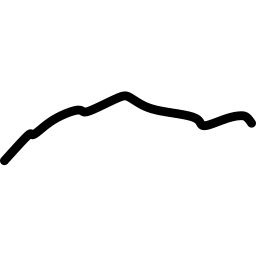

In [29]:
rd.render_img(
    [p], 
    img_path=None, 
    show=False,
    side=256,
    line_diameter=1,
    padding=0,
    bg_color=(0,0,0),
    fg_color=(1,1,1),
    original_side = 28.,
    convert = True,
)

## Raw pixel images

## CLIP features

## Inception V3 features

# GMM clustering

## Visualize clusters